<a href="https://colab.research.google.com/github/arijeetchoudhury100/disaster_real_fake_kaggle/blob/master/disaster_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install demoji

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import demoji
import re
import string
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,Dropout,SpatialDropout1D

In [0]:
def clean_tweets(tweet):
  #convert to lower case
  tweet = tweet.strip().lower()
  #remove http links
  tweet = re.sub('https?://\S+','',tweet)
  #remove html tags
  tweet = re.sub('<.*?>','',tweet)
  #remove hashtags
  tweet = re.sub('#','',tweet)
  return tweet

In [0]:
tweets_train = pd.read_csv('train.csv')
tweets_test = pd.read_csv('test.csv')
print(tweets_train.head())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]


In [0]:
print("total no. of training samples:",len(tweets_train))
print("total np. of testing samples:",len(tweets_test))

total no. of training samples: 7613
total np. of testing samples: 3263


Text(0, 0.5, 'counts')

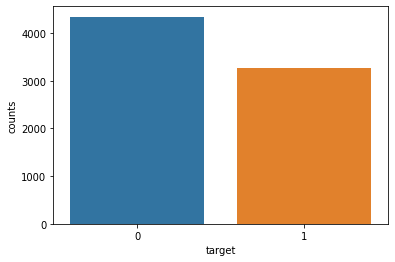

In [0]:
#check class distribution
class_dist = tweets_train['target'].value_counts()
sns.barplot(class_dist.index,class_dist)
plt.gca().set_xlabel('target')
plt.gca().set_ylabel('counts')

In [0]:
tweets_train['cleaned_text'] = tweets_train['text'].apply(clean_tweets)
print(tweets_train.head(5))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1             forest fire near la ronge sask. canada
2   5     NaN  ...      1  all residents asked to 'shelter in place' are ...
3   6     NaN  ...      1  13,000 people receive wildfires evacuation ord...
4   7     NaN  ...      1  just got sent this photo from ruby alaska as s...

[5 rows x 6 columns]


In [0]:
demoji.download_codes()

... OK (Got response in 0.38 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [0]:
#example use of demoji
tweet = """\
... #startspreadingthenews yankees win great start by 🎅🏾 going 5strong innings with 5k’s🔥 🐂
... solo homerun 🌋🌋 with 2 solo homeruns and👹 3run homerun… 🤡 🚣🏼 👨🏽‍⚖️ with rbi’s … 🔥🔥
... 🇲🇽 and 🇳🇮 to close the game🔥🔥!!!….
... WHAT A GAME!!..
... """
demoji.findall(tweet)
tweet = demoji.replace(tweet,'')
print(tweet)

... #startspreadingthenews yankees win great start by  going 5strong innings with 5k’s 
... solo homerun  with 2 solo homeruns and 3run homerun…    with rbi’s … 
...  and  to close the game!!!….
... WHAT A GAME!!..
... 


In [0]:
def remove_emojis(tweet):
  tweet = demoji.replace(tweet,'')
  return tweet

In [0]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(remove_emojis)
print(tweets_train.head(2))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1             forest fire near la ronge sask. canada

[2 rows x 6 columns]


In [0]:
#remove punctuations
#reference: https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
def remove_punctuation(tweet): 
    # punctuation marks 
    translator = str.maketrans('','',string.punctuation)
    return tweet.translate(translator)

In [0]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(remove_punctuation)
print(tweets_train.head(2))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1              forest fire near la ronge sask canada

[2 rows x 6 columns]


In [0]:
#create training set
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
data = []
for tweet in tweets_train['cleaned_text']:
  words = tweet.split()
  temp = [word for word in words if word not in stopword and word.isalpha()==1]
  data.append(" ".join(temp))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
print(len(data))

7613


In [0]:
labels = tweets_train['target'].values
print(len(labels))

7613


In [110]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index)
print('total no. of words:',vocab_size)

total no. of words: 16117


In [0]:
#convert text to sequence of tokens
sequences = tokenizer.texts_to_sequences(data)
max_len = max([len(s) for s in sequences])
print('max sequence length =',max_len)
#pad the sequences
padded_sequences =  pad_sequences(sequences,maxlen=max_len,padding='post')

max sequence length = 23


In [0]:
def load_glove(path):
  word_to_embedding = {}
  with open(path) as fh:
    for line in fh:
      line = line.strip().split()
      word = line[0]
      word_to_embedding[word] = np.array(line[1:],dtype = 'float32')
  return word_to_embedding

In [109]:
word_to_embedding = load_glove('drive/My Drive/glove.6B.50d.txt')
print(len(word_to_embedding))

400000


In [0]:
#create embedding matrix
def create_embedding(word_to_embedding,vocab_size,word_index,embed_dim):
  embeddings = np.zeros((vocab_size+1,embed_dim))
  for word,idx in word_index.items():
    embed_vec = word_to_embedding.get(word)
    if embed_vec is not None:
      embeddings[idx,:] = embed_vec
  return embeddings

In [112]:
embed_dim = 50
embed_matrix = create_embedding(word_to_embedding,vocab_size,word_to_index,embed_dim)
print(embed_matrix.shape)

(16118, 50)
